In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import astropy.units as u

%matplotlib inline

## DM-phase and DM-power

A common question is how to properly measure the Dispersion Measure of an FRB, in the presence of intrinsic pulse structures.  

Just by maximizing signal to noise, you can commonly arrive at the incorrect (often overestimated DM) due to intrinsic emission sweeping to lower frequency over time, or with scattering shifting the centroid more at low frequency ($\sim \lambda^4$)

A common approach is to search for 'structure maximizing' DM.  The underlying assumption is that the narrowest-time structures are emitted at the same time, so with the correct DM, the finest time structure will be preserved

The idea is to look at the Fourier transform in time of burst spectra at many dispersion measure trials - fine time structures correspond to power at high Fourier frequencies.  I show an example of applying DM-phase and DM-power algorithms, two very similar algorithms which attempt this

## First, simulate a burst

In this case, I add a sharp feature, and a 'sad-trombone' like structure descending in frequency

In [2]:
def simulate_burst(
    time, freq,
    peak_time, peak_freq,
    width_time, width_freq,
    drift_rate=0.0, drift_quadratic=0.0,
    amplitude=1.0,
    mod_amp=0.0, mod_freq=0.0, mod_phase=0.0
):
    """
    Simulate a drifting burst in a time-frequency array, with optional sinusoidal time modulation.

    Parameters:
        time (1D array): Time axis values.
        freq (1D array): Frequency axis values.
        peak_time (float): Central time of the burst.
        peak_freq (float): Central frequency at peak_time.
        width_time (float): Stddev of burst in time.
        width_freq (float): Stddev of burst in frequency.
        drift_rate (float): Linear drift (MHz/s).
        drift_quadratic (float): Quadratic drift term (MHz/s^2).
        amplitude (float): Peak amplitude.
        mod_amp (float): Amplitude of sinusoidal modulation (0 = no modulation).
        mod_freq (float): Frequency of modulation in Hz.
        mod_phase (float): Phase offset of modulation in radians.

    Returns:
        2D array of shape (len(time), len(freq)).
    """
    T, F = np.meshgrid(time, freq, indexing='ij')  # Shape: (time, freq)

    # Drift in frequency center as a function of time
    freq_center_t = peak_freq + drift_rate * (T - peak_time) + drift_quadratic * (T - peak_time)**2

    # 2D Gaussian burst envelope
    burst = amplitude * np.exp(
        -0.5 * ((T - peak_time) / width_time)**2
        -0.5 * ((F - freq_center_t) / width_freq)**2
    )

    # Sinusoidal modulation in time (optional)
    if mod_amp != 0.0 and mod_freq != 0.0:
        modulation = 1+mod_amp * np.sin(2 * np.pi * mod_freq * (T - peak_time) + mod_phase)
        burst *= modulation

    return burst

Text(0, 0.5, 'frequency (MHz)')

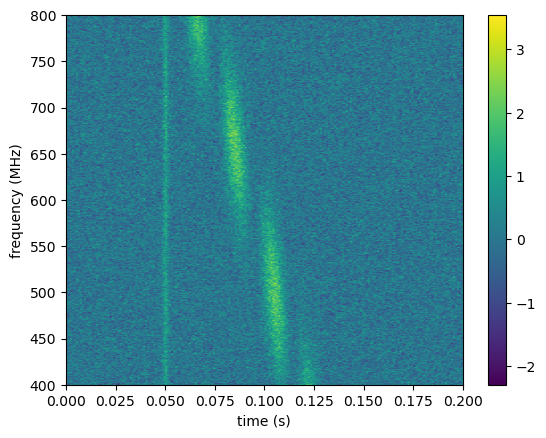

In [3]:
# Time and frequency axes
time = np.linspace(0, 0.2, 200)       # seconds
freq = np.linspace(400, 800, 512)     # MHz
# arb reference for DM
f_ref = max(freq)

# Define bursts as dictionaries
bursts = [
    {
        "peak_time": 0.08,
        "peak_freq": 700.0,
        "width_time": 0.1,
        "width_freq": 50.0,
        "drift_rate": -8000.0,
        "amplitude": 1.0,
        "mod_amp": 1.0,
        "mod_freq": 10000.,
        "mod_phase": 0.0,
    },
    {
        "peak_time": 0.05,
        "peak_freq": 600.0,
        "width_time": 0.001,
        "width_freq": 500.0,
        "drift_rate": 0.0,
        "amplitude": 1.0,
    }
]

# Initialize the dynamic spectrum
dynspec_noiseless = np.zeros((len(time), len(freq)))

# Loop through bursts and sum
for b in bursts:
    dynspec_noiseless += simulate_burst(time=time, freq=freq, **b)
    
noise = 0.5
dynspec = dynspec_noiseless + noise*np.random.normal(size=dynspec_noiseless.shape)

plt.imshow(dynspec.T, aspect='auto', origin='lower',
          extent=[0, max(time), min(freq), max(freq)])
plt.colorbar()
plt.xlabel('time (s)')
plt.ylabel('frequency (MHz)')

## Test DM-phase or DM-power algorithm

DM-power works as such:
For each trial DM:
- Disperse the burst
- Sum the dispersed burst over frequency
- Fourier transform across time, forming I(f_t, DMi)

DM-phase works as such:
For each trial DM:
- Disperse the burst
- FFT across time
- Sum the phase across frequency

Then you have an array $I(f_t, DM)$.  The correct DM shows power to highest $f_t$

In [4]:
def shift2(z, dt):
    """
    2D sub-bin shifting, shifting axis 0
    returns z shifted by dt in units of cycle (ie., dt=1 returns the same z).
    Arguments
    ---------
    z :
        Profile to shift
    dt :
        Phase to shift
    """

    ngates = z.shape[-1]
    freqs = np.fft.rfftfreq(ngates,1./ngates)
    return np.real(np.fft.irfft(np.exp(-1j*2*np.pi*freqs[np.newaxis,:]*dt)*np.fft.rfft(z,axis=-1),axis=-1))

Text(0.5, -0.05, 'Left: the burst profile I(t) at every trial DM.  Right: the power I(f_t) at each trial DM\nEven though there are peaks in the SN offset from dDM=0, the power extends to highest $f_t$ at DM=0')

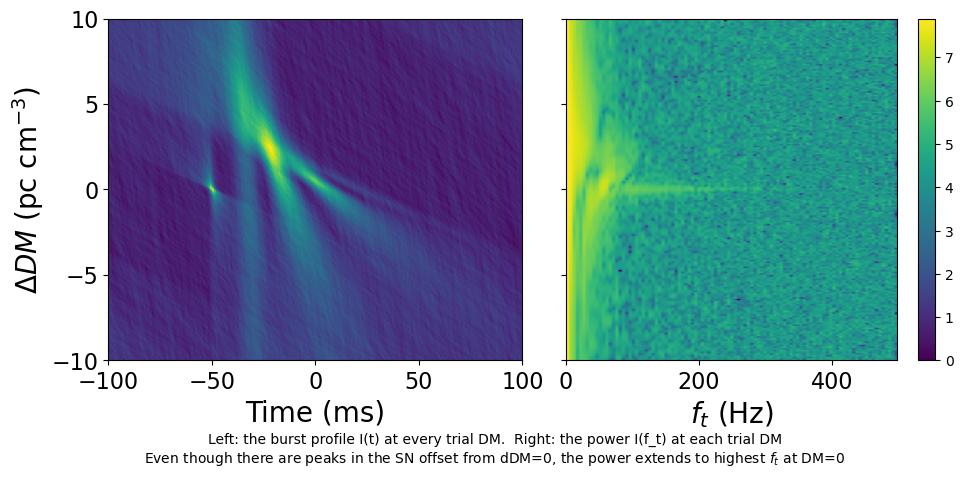

In [5]:
# Choose DM_phase or DM_power
mode = 'power'
#mode = 'phase'

# DM0 doesn't actually matter, we only are modifying with Delta DM
DMrange = np.linspace(-10,10, 201)
tsamp = (time[1] - time[0])*u.s

Ttotal = dynspec.shape[0] * tsamp

structure = []
for k,DM in enumerate(DMrange):
    t_delay = (1/2.41e-4) * DM * (1./f_ref**2 - 1./freq**2)
    pshift = (t_delay/Ttotal).decompose().value
    power = shift2(dynspec.T, pshift[:,np.newaxis])
    
    # now power has axes of Freq, Time
    profi = np.sum(power, axis=0)
    structure.append(profi)

    if mode == 'phase':
        FT = np.fft.rfft(power, axis=-1)
        if k == 0:
            FTarray = np.zeros((len(DMrange), FT.shape[1]))
        amp = np.abs(FT)
        amp[amp==0] = 1
        FTphase = FT / amp
        FTi = np.abs(np.sum(FTphase, axis=0))        
        FTarray[k] = FTi

structure = np.array(structure)
if mode == 'power':
    FTarray = np.fft.rfft(structure, axis=1)


ps = np.abs(FTarray)**2

taxis = tsamp.to(u.ms).value*np.arange(dynspec.shape[0])
taxis = taxis-np.mean(taxis)

rftfreq = np.fft.rfftfreq(structure.shape[1], d=tsamp)
rftfreq = rftfreq.to(u.Hz).value

fig = plt.figure(figsize=(10,4.5))
plt.subplots_adjust(wspace=0.1)

ax1 = plt.subplot(121)
plt.imshow(structure, extent=[min(taxis), max(taxis), 
                              min(DMrange), max(DMrange)], origin='lower', aspect='auto')

plt.xlabel('Time (ms)', fontsize=20)
plt.ylabel(r'$\Delta DM$ (pc cm$^{-3}$)', fontsize=20)

ax1.tick_params(axis='both', which='major', labelsize=16)

ax2 = plt.subplot(122)
plt.imshow(np.log10(ps), aspect='auto', origin='lower', vmin=0, 
           extent=[min(rftfreq), max(rftfreq), min(DMrange), max(DMrange)])
plt.yticks()

ax2.set_yticklabels([])
plt.xlabel(r'$f_{t}$ (Hz)', fontsize=20)
ax2.tick_params(axis='both', which='major', labelsize=16)
plt.colorbar()
plt.tight_layout()

txt = ('Left: the burst profile I(t) at every trial DM.  Right: the power I(f_t) at each trial DM', 
       'Even though there are peaks in the SN offset from dDM=0, the power extends to highest $f_t$ at DM=0')
fig.text(.5, -0.05, "\n".join(txt), ha='center', va='bottom', wrap=True)

## Step by step through one example for DM-phase

In [ ]:
power = np.copy(dspec.T)
DMrange = [-5, 0, 5]

fig, axes = plt.subplots(len(DMrange), 2, figsize=(10, 8))
# axes has shape (3, 2): left column = power, right column = FTphase
FTprofs = []

for k, DM in enumerate(DMrange):
    t_delay = (1/2.41e-4) * DM * (1./f_ref**2 - 1./freq**2)
    pshift = (t_delay/Ttotal).decompose().value
    power = shift2(dynspec.T, pshift[:, np.newaxis])
    
    # Power: freq vs time
    im0 = axes[k, 0].imshow(
        power,
        aspect='auto',
        origin='lower',
        extent=[0, power.shape[1], freq.min(), freq.max()]
    )
    if k == 0:
        axes[k, 0].set_title(f"Power")
        axes[k, 1].set_title(f"FT Phase")

    plt.colorbar(im0, ax=axes[k, 0], fraction=0.046)

    # Fourier transform along time axis
    FT = np.fft.rfft(power, axis=-1)
    amp = np.abs(FT)
    amp[amp == 0] = 1
    FTphase = FT / amp
    FTi = np.abs(np.sum(FTphase, axis=0))

    im1 = axes[k, 1].imshow(
        np.angle(FTphase),
        aspect='auto',
        origin='lower',
        extent=[0, max(rftfreq), freq.min(), freq.max()],
        cmap = 'bwr'
    )
    plt.colorbar(im1, ax=axes[k, 1], fraction=0.046)

    if k == 1:
        axes[k,0].set_ylabel('Frequency (MHz)')
    if k ==2:
        axes[k,0].set_xlabel('f_t (mHz)')
        axes[k,1].set_xlabel('f_t (mHz)')
        
    
    FTprofs.append(FTi)
    
    
plt.figure(figsize=(6,3))
for i in range(len(DMrange)):
    plt.plot(rftfreq, FTprofs[i], label=f'd DM={DMrange[i]}')
plt.legend()
plt.yscale('log')
plt.xlabel('f_t (mHz)')
plt.ylabel('I (arb)')

## Additional test: are DM-phase and DM-power biased by scattering?

In this case, I am convolving with 2 scattering screens - the second convolution causes a rise-time, which will shift the peak of even intrinsically sharp emission, so could potentially cause an apparent DM difference

In [ ]:
def convolve_tail(pulse, t, tau):
    tail = np.exp(-t/tau)
    tail /= np.sum(tail)
    scattered_pulse = np.fft.irfft( np.fft.rfft(pulse) * np.fft.rfft(tail[::-1]).conj() )
    scattered_pulse = scattered_pulse
    return scattered_pulse

def convolve2(pulse, t, tau1, tau2):
    scattered_pulse = convolve_tail(pulse, t, tau1)
    scattered_pulse = convolve_tail(scattered_pulse, t, tau2)
    return scattered_pulse
    
plt.imshow(dynspec.T, aspect='auto', origin='lower')
plt.colorbar()

# Optionally convolve with scattering tail
tau1_0 = 0.004
tau2_0 = 0.001

dynspec_convolved = np.zeros_like(dynspec)
for i in range(len(freq)):
    pulsei = dynspec_noiseless[:,i]
    tau1 = tau1_0 * (freq[i]/f_ref)**(-4)
    tau2 = tau2_0 * (freq[i]/f_ref)**(-4)

    pulsei = convolve2(pulsei, time, tau1, tau2)
    dynspec_convolved[:,i] = pulsei

noise = 0.02
dynspec_convolved += noise*np.random.normal(size=dynspec.shape)

plt.figure()
plt.imshow(dynspec_convolved.T, aspect='auto', origin='lower')
plt.colorbar()

In [ ]:
# Choose DM_phase or DM_power
mode = 'power'
#mode = 'phase'

# DM0 doesn't actually matter, we only are modifying with Delta DM
DMrange = np.linspace(-10,10, 201)
tsamp = (time[1] - time[0])*u.s

Ttotal = dynspec.shape[0] * tsamp

structure = []
for k,DM in enumerate(DMrange):
    t_delay = (1/2.41e-4) * DM * (1./f_ref**2 - 1./freq**2)
    pshift = (t_delay/Ttotal).decompose().value
    power = shift2(dynspec_convolved.T, pshift[:,np.newaxis])
    
    # now power has axes of Freq, Time
    profi = np.sum(power, axis=0)
    structure.append(profi)

    if mode == 'phase':
        FT = np.fft.rfft(power, axis=-1)
        if k == 0:
            FTarray = np.zeros((len(DMrange), FT.shape[1]))
        amp = np.abs(FT)
        amp[amp==0] = 1
        FTphase = FT / amp
        FTi = np.abs(np.sum(FTphase, axis=0))        
        FTarray[k] = FTi

structure = np.array(structure)
if mode == 'power':
    FTarray = np.fft.rfft(structure, axis=1)


ps = np.abs(FTarray)**2

taxis = tsamp.to(u.ms).value*np.arange(dynspec.shape[0])
taxis = taxis-np.mean(taxis)

rftfreq = np.fft.rfftfreq(structure.shape[1], d=tsamp)
rftfreq = rftfreq.to(u.Hz).value

fig = plt.figure(figsize=(10,4.5))
plt.subplots_adjust(wspace=0.1)

ax1 = plt.subplot(121)
plt.imshow(structure, extent=[min(taxis), max(taxis), 
                              min(DMrange), max(DMrange)], origin='lower', aspect='auto')

plt.xlabel('Time (ms)', fontsize=20)
plt.ylabel(r'$\Delta DM$ (pc cm$^{-3}$)', fontsize=20)

ax1.tick_params(axis='both', which='major', labelsize=16)

ax2 = plt.subplot(122)
plt.imshow(np.log10(ps), aspect='auto', origin='lower', vmin=0, 
           extent=[min(rftfreq), max(rftfreq), min(DMrange), max(DMrange)])
plt.yticks()

ax2.set_yticklabels([])
plt.xlabel(r'$f_{t}$ (Hz)', fontsize=20)
ax2.tick_params(axis='both', which='major', labelsize=16)
plt.colorbar()
plt.tight_layout()

txt = ('Power is still aligned at correct DM, but at reduced SN')
fig.text(.5, .0, txt, ha='center')